# Fine-tuning xgboost

This notebook is a continuation of the *main.ipynb*, where I will specifically fine-tune the xgboost model to the problem described in that notebook.

## Data

Let's import the data and split it in train and test set using the same configuration as used in the *main.ipynb*.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split


X = pd.read_csv('processed_public.csv', low_memory=False).dropna(subset='espera')
y = X['espera']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=y,
)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(f"{y_train.mean():.4f}", f"{y_test.mean():.4f}")

(169343, 122) (169343,)
(42336, 122) (42336,)
0.0174 0.0174


## Features

Let's use the same transformers for feature engineering as defined in *main.ipynb*.

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin

class TimeInformation(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        time_data = pd.to_datetime(X['hora_ref'])
        b = [0, 4, 8, 12, 16, 20, 24]
        l = ['late night', 'early morning', 'morning', 'noon', 'evening', 'night']
        X['period_day'] = pd.cut(time_data.dt.hour, bins=b, labels=l, include_lowest=True)
        X['day_of_week'] =  pd.Categorical(time_data.dt.day_of_week)
        return X

class CabeceiraTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X['prev_troca_cabeceira'] = X['prev_troca_cabeceira'].astype(bool)
        X['troca_cabeceira_hora_anterior'] = X['troca_cabeceira_hora_anterior'].astype(bool)
        return X


class CombineMetarTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, cat_features=None, num_features=None):
        self.cat_features = cat_features
        self.num_features = num_features
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        for feature in self.cat_features:
            X[feature] = X[f'{feature}_metar'].fillna(X[f'{feature}_metaf'])
            # X.drop(columns=[f'{feature}_metar', f'{feature}_metaf'], inplace=True)
        for feature in self.num_features:
            X[feature] = X[[f'{feature}_metar', f'{feature}_metaf']].mean(axis=1)
            # X.drop(columns=[f'{feature}_metar', f'{feature}_metaf'], inplace=True)
        return X

class RouteTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X['route'] = X['origem'] + '-' + X['destino']
        return X

# # TODO implement origem destino in this one
# class WindDirectionTransformer(TransformerMixin, BaseEstimator):
#     def fit(self, X, y=None):
#         return self

#     def transform(self, X, y=None):
#         X['wind_direction_vrb_origem'] = False
#         wind_direction_vrb = (X['wind_direction_origem_mean'].isna()) & (X['metar'].str.contains('VRB'))
#         X.loc[wind_direction_vrb, 'wind_direction_vrb'] = True
#         return X


class WeatherTransformer(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X['current_wx_origem'] = X['current_wx1_origem'].fillna('') + X['current_wx2_origem'].fillna('') + X['current_wx3_origem'].fillna('')
        X['current_wx_destino'] = X['current_wx1_destino'].fillna('') + X['current_wx2_destino'].fillna('') + X['current_wx3_destino'].fillna('')

        intensity_cat = ['VC', '-', '', '+']
        descriptor_cat = ['MI', 'PR', 'BC', 'DR', 'BL', 'SH', 'TS', 'FZ']
        descriptor_cat = [i+d for i in intensity_cat for d in descriptor_cat]
        precipitation_cat = ['DZ', 'RA', 'SN', 'SG', 'IC', 'PL', 'GR', 'GS', 'UP']
        precipitation_cat = [i+d for i in intensity_cat for d in precipitation_cat]
        obscuration_cat = ['BR', 'FG', 'FU', 'VA', 'DU', 'SA', 'HZ', 'PY']
        obscuration_cat = [i+d for i in intensity_cat for d in obscuration_cat]
        other_cat = ['PO', 'SQ', 'FC', 'SS', 'DS']
        other_cat = [i+d for i in intensity_cat for d in other_cat]
        weather_categories = descriptor_cat + precipitation_cat + obscuration_cat + other_cat

        X['current_wx_origem'] = pd.Categorical(X['current_wx_origem'], categories=weather_categories)
        X['current_wx_destino'] = pd.Categorical(X['current_wx_destino'], categories=weather_categories)
        
        # X.drop(columns=[f'current_wx{i}_{source}' for i in range(1,4) for source in ['origem', 'destino']], inplace=True)
        return X

In [3]:
from sklearn.pipeline import Pipeline
pd.options.mode.chained_assignment = None

metar_num_features = ['wind_direction', 
                      'wind_speed', 
                      'wind_gust', 
                      'visibility', 
                      'low_cloud_level', 
                      'medium_cloud_level', 
                      'high_cloud_level', 
                      'highest_cloud_level', 
                      'cloud_coverage', 
                      'air_temperature', 
                      'dew_point_temperature',
                      'altimeter',
                      'elevation',
                     ]
metar_num_features = [f+'_origem' for f in metar_num_features] + [f+'_destino' for f in metar_num_features]

metar_cat_features = ['low_cloud_type', 
                      'medium_cloud_type', 
                      'high_cloud_type', 
                      'highest_cloud_type', 
                      'current_wx1',
                      'current_wx2',
                      'current_wx3',
                     ]
metar_cat_features = [f+'_origem' for f in metar_cat_features] + [f+'_destino' for f in metar_cat_features]

create_features_pipeline = Pipeline([
    ('route', RouteTransformer()),
    ('cabeceira', CabeceiraTransformer()),
    ('time', TimeInformation()),
    ('combine_metar', CombineMetarTransformer(
        cat_features=metar_cat_features,
        num_features=metar_num_features,
    )),
    # ('wind_vrb', WindDirectionTransformer()),
    ('weather', WeatherTransformer()),
])

In [4]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MultiLabelBinarizer

num_median_features = ['wind_direction', 'wind_speed', 'visibility', 'cloud_coverage', 'air_temperature', 'dew_point_temperature', 'altimeter', 'elevation']
num_median_features = [f+'_origem' for f in num_median_features] + [f+'_destino' for f in num_median_features]
num_median_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median', add_indicator=True)),
    ('scaler', StandardScaler()),
])

num_zero_features = ['wind_gust']
num_zero_features = [f+'_origem' for f in num_zero_features] + [f+'_destino' for f in num_zero_features]
num_zero_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler()),
])

# bin_features = ['prev_troca_cabeceira', 'troca_cabeceira_hora_anterior', 'wind_direction_vrb']
bin_features = ['prev_troca_cabeceira', 'troca_cabeceira_hora_anterior']
# bin_features = [f+'_origem' for f in bin_features] + [f+'_destino' for f in bin_features]
bin_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median', add_indicator=True)),
    ('scaler', StandardScaler()),
])

cat_features = ['origem', 'destino', 'route', 'period_day', 'day_of_week']
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent', add_indicator=True)),
    ('encoder', OneHotEncoder(handle_unknown='ignore')),
])

weather_features = ['current_wx']
weather_features = [f+'_origem' for f in weather_features] + [f+'_destino' for f in weather_features]
weather_pipeline = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

clouds_num_features = ['low_cloud_level', 'medium_cloud_level', 'high_cloud_level', 'highest_cloud_level']
clouds_num_features = [f+'_origem' for f in clouds_num_features] + [f+'_destino' for f in clouds_num_features]
clouds_num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=10000, add_indicator=True)),
    ('scaler', StandardScaler()),
])

clouds_cat_features = ['low_cloud_type', 'medium_cloud_type', 'high_cloud_type', 'highest_cloud_type']
clouds_cat_features = [f+'_origem' for f in clouds_cat_features] + [f+'_destino' for f in clouds_cat_features]
clouds_cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='SKC')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

data_pipeline = ColumnTransformer([
    ('num_median', num_median_pipeline, num_median_features),
    ('num_zero', num_zero_pipeline, num_zero_features),
    ('binary', bin_pipeline, bin_features),
    ('cat', cat_pipeline, cat_features),
    ('weather', weather_pipeline, weather_features),
    ('clouds_num', clouds_num_pipeline, clouds_num_features),
    ('clouds_cat', clouds_cat_pipeline, clouds_cat_features),
])

## Model

I'll be using the XGBoost model for this one, with adversarial sampling as described in *adversarial.ipynb*.

In [5]:
sample_weight = pd.read_csv('sample_weight_4.csv', index_col=0).loc[X_train.index, '0'].values
print(len(sample_weight))

169343


### Feature importance

Let's have a look at the feature importances of the base XGBoost model. This might give us some insight about the features engineered before.

In [10]:
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.feature_selection import VarianceThreshold

clf = Pipeline([
    ('features', create_features_pipeline),
    ('data', data_pipeline),
    ('selector', VarianceThreshold()),
    ('model', XGBClassifier())
])

clf.fit(X_train, y_train, model__sample_weight=sample_weight)

Pipeline(steps=[('features',
                 Pipeline(steps=[('route', RouteTransformer()),
                                 ('cabeceira', CabeceiraTransformer()),
                                 ('time', TimeInformation()),
                                 ('combine_metar',
                                  CombineMetarTransformer(cat_features=['low_cloud_type_origem',
                                                                        'medium_cloud_type_origem',
                                                                        'high_cloud_type_origem',
                                                                        'highest_cloud_type_origem',
                                                                        'current_wx1_origem',
                                                                        'current_wx2_origem',
                                                                        'current_wx3...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

Number of features: 289


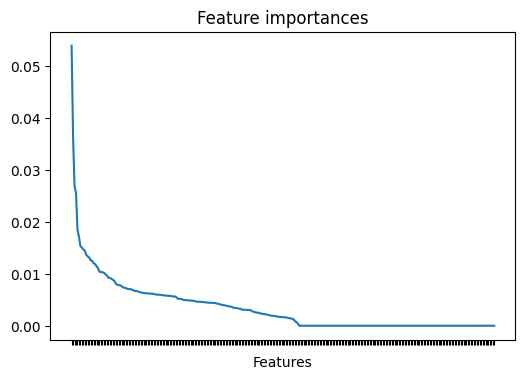

In [11]:
import matplotlib.pyplot as plt

features = [f.split('__')[-1] for f in clf.named_steps['data'].get_feature_names_out()]

print(f'Number of features: {len(features)}')
feature_importance = pd.Series(clf.named_steps['model'].feature_importances_, index=features).sort_values(ascending=False)

fig, ax = plt.subplots(1, figsize=(6,4))
ax.set_xticklabels([])
ax.plot(feature_importance)
ax.set_title('Feature importances')
ax.set_xlabel('Features')
plt.show()

In [12]:
print('Most important features')
print(feature_importance.head(20))

Most important features
missingindicator_air_temperature_origem        0.053924
current_wx_origem_BR                           0.036312
route_SBCT-SBKP                                0.026907
current_wx_origem_-RA                          0.025584
destino_SBSP                                   0.018539
route_SBGL-SBGR                                0.017148
missingindicator_medium_cloud_level_destino    0.015307
day_of_week_6                                  0.015061
route_SBRJ-SBSV                                0.014670
destino_SBBR                                   0.014473
destino_SBRJ                                   0.013619
route_SBCF-SBRJ                                0.013371
route_SBCF-SBSP                                0.013119
day_of_week_1                                  0.012591
current_wx_destino_RA                          0.012508
destino_SBKP                                   0.012007
route_SBPA-SBSP                                0.011877
destino_SBRF            

We see that the most important features are related to the destination of the flight, as well as weather conditions such as the cloud types, precipitations, and wind information. It is interesting to see that the most useful information for the model is actually related to the conditions at **destination**, and not at departure.

In [13]:
unimportant_features = feature_importance[feature_importance == 0]
print(f'Number of unimportant features: {len(unimportant_features)}')
print(*(f for f in set([f.replace(f.split('_')[-1], '')[:-1] for f in unimportant_features.index])), sep='\n')

Number of unimportant features: 134
route
missingindicator_low_cloud_level
low_cloud_type_origem
missingindicator_elevation
current_wx_destino
high_cloud_type_origem
medium_cloud_type_origem
highest_cloud_type_origem
current_wx_origem
missingindicator_air_temperature
low_cloud_type_destino
missingindicator_cloud_coverage
high_cloud_type_destino
highest_cloud_type_destino
missingindicator_dew_point_temperature
medium_cloud_type_destino
missingindicator_altimeter
missingindicator_visibility


Out of the 289 features initially selected, 134 are unimportant for the model.

We could explore some feature engineering by iteratively selecting features using the feature importance. This won't be done for now and is left as a future exploration.

### Grid search

I now proceed to do some fine-tuning on the base model.

We will explore a few parameters, namely:
- *n_estimators*:
- *scale_pos_weight*:
- *max_depth* and *min_child_weight*:
- *gamma*:
- *subsample* and *colsample_bytree*:
- *max_delta_step*:
- *reg_alpha*:

The goal is to use grid search cross validation to find the best parameters using ROC AUC as a metric over the validation set.

In [19]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import time
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

def my_grid_search(param_clf, param_grid):
    clf = Pipeline([
        ('features', create_features_pipeline),
        ('data', data_pipeline),
        ('selector', VarianceThreshold()),
        ('model', XGBClassifier(**param_clf))
    ])

    cv = StratifiedKFold(n_splits=5)
    gsearch = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='roc_auc', n_jobs=-1, cv=cv, refit=False)
    start = time.time()
    gsearch.fit(X_train, y_train, model__sample_weight=sample_weight)
    print(f'time = {round(time.time()-start, 2)}s')
    print(gsearch.best_params_, gsearch.best_score_)

In [20]:
param_grid = {
    'model__n_estimators': [10, 100, 300, 500],
     # 'model__n_estimators': range(200,450,50),
    # 'model__n_estimators': [10, 100],
}

param_clf = {
    'learning_rate': 0.3,
}

my_grid_search(param_clf, param_grid)

time = 76.51s
{'model__n_estimators': 300} 0.7773884538111081


In [22]:
param_grid = {
    'model__scale_pos_weight': [1, 10, 40, 70, 100],
}

param_clf = {
    'learning_rate': 0.3,
    'n_estimators': 300,
}

my_grid_search(param_clf, param_grid)

time = 105.71s
{'model__scale_pos_weight': 10} 0.7829813881873809


In [27]:
param_grid = {
    # 'model__max_depth': range(3,10,2),
    'model__max_depth': [3, 6, 11],
    'model__min_child_weight': [0, 1, 3],
}

param_clf = {
    'learning_rate': 0.3,
    'n_estimators': 300,
    'scale_pos_weight': 10,
}

my_grid_search(param_clf, param_grid)

time = 196.36s
{'model__max_depth': 11, 'model__min_child_weight': 0} 0.784249377411897


In [28]:
param_grid = {
    'model__max_depth': [15, 19],
    'model__min_child_weight': [0, 1],
}

param_clf = {
    'learning_rate': 0.3,
    'n_estimators': 300,
    'scale_pos_weight': 10,
}

my_grid_search(param_clf, param_grid)

time = 219.76s
{'model__max_depth': 19, 'model__min_child_weight': 0} 0.7850443717237059


In [29]:
param_grid = {
    'model__gamma': [0.1, 1, 3, 10, 100],
}

param_clf = {
    'learning_rate': 0.3,
    'n_estimators': 300,
    'scale_pos_weight': 10,
    'max_depth': 11,
    'min_child_weight': 0,
}

my_grid_search(param_clf, param_grid)

time = 73.42s
{'model__gamma': 0.1} 0.7904694965173666


In [30]:
param_grid = {
    'model__gamma': [0.2, 0.3, 0.6],
}

param_clf = {
    'learning_rate': 0.3,
    'n_estimators': 300,
    'scale_pos_weight': 10,
    'max_depth': 11,
    'min_child_weight': 0,
}

my_grid_search(param_clf, param_grid)

time = 49.64s
{'model__gamma': 0.3} 0.793019466484126


In [33]:
param_grid = {
    'model__subsample': [0.1, 0.5, 0.9],
    'model__colsample_bytree':[0.2, 0.5, 0.8],
}

param_clf = {
    'learning_rate': 0.3,
    'n_estimators': 300,
    'scale_pos_weight': 10,
    'max_depth': 11,
    'min_child_weight': 0,
    'gamma': 0.3,
}

my_grid_search(param_clf, param_grid)

time = 260.57s
{'model__colsample_bytree': 0.2, 'model__subsample': 0.9} 0.7753712687817359


Decrease in performance compared to the defaults, so let's keep the default values 1.

In [34]:
param_grid = {
    'model__max_delta_step': [i/1.0 for i in range(0,5)],
}

param_clf = {
    'learning_rate': 0.3,
    'n_estimators': 300,
    'scale_pos_weight': 10,
    'max_depth': 11,
    'min_child_weight': 0,
    'gamma': 0.3,
    'subsample': 1,
    'colsample_bytree': 1,
}

my_grid_search(param_clf, param_grid)

time = 80.78s
{'model__max_delta_step': 0.0} 0.793019466484126


In [35]:
param_grid = {
    'model__reg_alpha': [1e-6, 1e-3, 1e-1, 10, 1000],
}

param_clf = {
    'learning_rate': 0.3,
    'n_estimators': 300,
    'scale_pos_weight': 10,
    'max_depth': 11,
    'min_child_weight': 0,
    'gamma': 0.3,
    'subsample': 1,
    'colsample_bytree': 1,
    'max_delta_step': 0.0,
}

my_grid_search(param_clf, param_grid)

time = 74.21s
{'model__reg_alpha': 1e-06} 0.7930207041574763


In [36]:
param_grid = {
    'model__reg_alpha': [1e-8, 1e-7, 1e-5, 1e-4],
}

param_clf = {
    'learning_rate': 0.3,
    'n_estimators': 300,
    'scale_pos_weight': 10,
    'max_depth': 11,
    'min_child_weight': 0,
    'gamma': 0.3,
    'subsample': 1,
    'colsample_bytree': 1,
    'max_delta_step': 0.0,
}

my_grid_search(param_clf, param_grid)

time = 62.36s
{'model__reg_alpha': 0.0001} 0.7937494350933451


With the final parameters, I'll search for a n_estimators again using a smaller learning_rate.

In [37]:
param_grid = {
    'model__n_estimators': [100, 300, 1000, 3000]
}

param_clf = {
    'learning_rate': 0.01,
    # 'n_estimators': 300,
    'scale_pos_weight': 10,
    'max_depth': 11,
    'min_child_weight': 0,
    'gamma': 0.3,
    'subsample': 1,
    'colsample_bytree': 1,
    'max_delta_step': 0.0,
    'reg_alpha': 1e-4,
}

my_grid_search(param_clf, param_grid)

time = 297.26s
{'model__n_estimators': 1000} 0.8078690203065729


### Final model

We now have the hypeparameters of the final model, which has a AUC score of 0.8078, an improvement of __ over the base model at *main.ipynb* of __.

In [6]:
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.feature_selection import VarianceThreshold

param_clf = {
    'learning_rate': 0.01,
    'n_estimators': 1000,
    'scale_pos_weight': 10,
    'max_depth': 11,
    'min_child_weight': 0,
    'gamma': 0.3,
    'subsample': 1,
    'colsample_bytree': 1,
    'max_delta_step': 0.0,
    'reg_alpha': 1e-4,
}

clf = Pipeline([
    ('features', create_features_pipeline),
    ('data', data_pipeline),
    ('selector', VarianceThreshold()),
    ('model', XGBClassifier(**param_clf))
])

clf.fit(X_train, y_train, model__sample_weight=sample_weight)

Pipeline(steps=[('features',
                 Pipeline(steps=[('route', RouteTransformer()),
                                 ('cabeceira', CabeceiraTransformer()),
                                 ('time', TimeInformation()),
                                 ('combine_metar',
                                  CombineMetarTransformer(cat_features=['low_cloud_type_origem',
                                                                        'medium_cloud_type_origem',
                                                                        'high_cloud_type_origem',
                                                                        'highest_cloud_type_origem',
                                                                        'current_wx1_origem',
                                                                        'current_wx2_origem',
                                                                        'current_wx3...
                               feature_types=None, gamma=0.3, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=0.0,
                               max_depth=11, max_leaves=None,
                               min_child_weight=0, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=1000, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

Number of features: 289


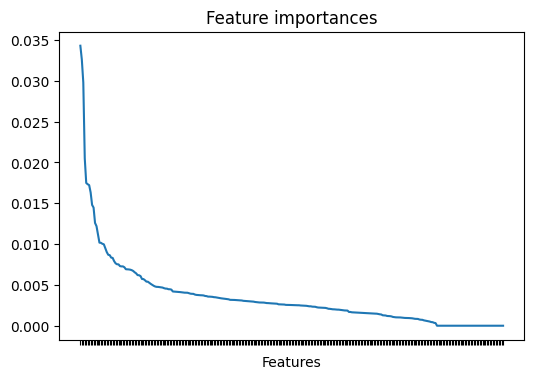

In [7]:
import matplotlib.pyplot as plt

features = [f.split('__')[-1] for f in clf.named_steps['data'].get_feature_names_out()]

print(f'Number of features: {len(features)}')
feature_importance = pd.Series(clf.named_steps['model'].feature_importances_, index=features).sort_values(ascending=False)

fig, ax = plt.subplots(1, figsize=(6,4))
ax.set_xticklabels([])
ax.plot(feature_importance)
ax.set_title('Feature importances')
ax.set_xlabel('Features')
plt.show()

In [11]:
print('Most important features')
most_important_features = feature_importance.head(20)
print(most_important_features)

Most important features
current_wx_origem_-DZ                          0.034300
destino_SBBR                                   0.032601
destino_SBSP                                   0.029794
route_SBCT-SBKP                                0.020491
destino_SBRF                                   0.017487
destino_SBRJ                                   0.017332
destino_SBPA                                   0.017222
missingindicator_medium_cloud_level_destino    0.016326
route_SBPA-SBCF                                0.014799
destino_SBSV                                   0.014473
current_wx_destino_RA                          0.012592
route_SBKP-SBGR                                0.012195
route_SBKP-SBCT                                0.011175
route_SBRJ-SBSV                                0.010177
medium_cloud_level_destino                     0.010156
missingindicator_altimeter_destino             0.010036
destino_SBKP                                   0.009972
route_SBFL-SBSP         

In [28]:
import numpy as np
unique_features = [('_'.join(f.split('_')[:-1]), x) for f, x in zip(feature_importance.index, feature_importance)]
most_important = {}
for f, v in unique_features:
    if f not in most_important:
        most_important[f] = []
    most_important[f].append(v)
sorted([(f, np.array(v).mean()) for f, v in most_important.items()], key=lambda x:x[1], reverse=True)

[('destino', 0.014201083957838515),
 ('missingindicator_medium_cloud_level', 0.00939911906607449),
 ('medium_cloud_level', 0.007377501809969544),
 ('missingindicator_high_cloud_level', 0.005837133969180286),
 ('elevation', 0.005136328749358654),
 ('missingindicator_altimeter', 0.005018037278205156),
 ('prev_troca', 0.0047283172607421875),
 ('current_wx_origem', 0.004458698177976268),
 ('altimeter', 0.004311169032007456),
 ('missingindicator_wind_speed', 0.004307628027163446),
 ('missingindicator_air_temperature', 0.004259239532984793),
 ('cloud_coverage', 0.004048991948366165),
 ('missingindicator_visibility', 0.00401105044875294),
 ('air_temperature', 0.003995024599134922),
 ('day_of_week', 0.003979025974071452),
 ('wind_speed', 0.003846805775538087),
 ('period_day', 0.0037678376926730075),
 ('low_cloud_level', 0.003610054263845086),
 ('low_cloud_type_destino', 0.0035976755898445845),
 ('wind_direction', 0.003577549825422466),
 ('visibility', 0.003529271809384227),
 ('dew_point_temper

We see that the final model gives more importance to the routes and weather information than the base model, which makes more sense given the knowledge of the problem.

In [42]:
unimportant_features = feature_importance[feature_importance == 0]
print(f'Number of unimportant features: {len(unimportant_features)}')
print(*(f for f in set([f.replace(f.split('_')[-1], '')[:-1] for f in unimportant_features.index])), sep='\n')

Number of unimportant features: 46
route
missingindicator_low_cloud_level
missingindicator_elevation
current_wx_destino
high_cloud_type_origem
medium_cloud_type_origem
highest_cloud_type_origem
current_wx_origem
low_cloud_type_destino
missingindicator_cloud_coverage
high_cloud_type_destino
missingindicator_dew_point_temperature
medium_cloud_type_destino
missingindicator_altimeter
highest_cloud_type_destino


Out of the 289 features initially selected, only 46 are now unimportant for the model.

As discussed, we could now explore some feature engineering by iteratively selecting features using the feature importance. This won't be done for now and is left as a future exploration.

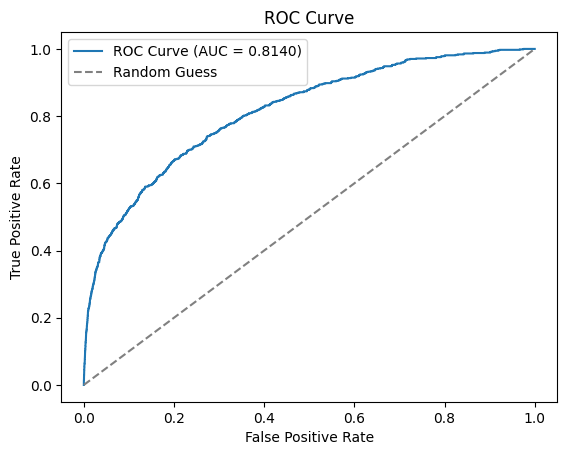

In [54]:
from sklearn.metrics import roc_curve, roc_auc_score

pred_proba = clf.predict_proba(X_test)[:,1]

auc = roc_auc_score(y_test, pred_proba)
fpr, tpr, _ = roc_curve(y_test, pred_proba)
plt.plot(fpr, tpr, label = 'ROC Curve (AUC = %0.4f)' % auc)

plt.plot([0,1], [0,1], linestyle = '--', color = 'gray', label = 'Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

The final model obtains a ROC AUC score of 0.8140 on the test set, separated at the beginning of the training and never seen by it.

## Probability calibration

Before submitting the predictions, let's have a look at the f1-score for different thresholds.

In [56]:
from sklearn.metrics import f1_score

for th in range(1, 11, 1):
    th /= 10
    y_pred = (pred_proba > th).astype(int)
    print(f'{th}: {f1_score(y_test, y_pred)}')

0.1: 0.11581001951854261
0.2: 0.19072615923009623
0.3: 0.23712801133679737
0.4: 0.24778761061946902
0.5: 0.24807395993836673
0.6: 0.2192513368983957
0.7: 0.18731117824773413
0.8: 0.12684031710079274
0.9: 0.05844980940279543
1.0: 0.0


In [58]:
from sklearn.metrics import f1_score

for th in range(40, 60, 1):
    th /= 100
    y_pred = (pred_proba > th).astype(int)
    print(f'{th}: {f1_score(y_test, y_pred)}')

0.4: 0.24778761061946902
0.41: 0.24774193548387097
0.42: 0.24769433465085638
0.43: 0.24696356275303644
0.44: 0.24566273421235255
0.45: 0.24349049964813513
0.46: 0.24431818181818182
0.47: 0.24727272727272728
0.48: 0.2485207100591716
0.49: 0.25037707390648567
0.5: 0.24807395993836673
0.51: 0.24605678233438485
0.52: 0.24300559552358114
0.53: 0.2392886014551334
0.54: 0.2369281045751634
0.55: 0.22904564315352696
0.56: 0.22934232715008432
0.57: 0.2289156626506024
0.58: 0.22319093286835223
0.59: 0.2185022026431718


The best f1-score for the test data indeed happens for a threshold at 0.5. So let's use this information to predict the submission data.

In [60]:
from joblib import dump
dump(clf, 'xgb_th05_auc_08140.joblib')

['xgb_th05_auc_08140.joblib']